# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

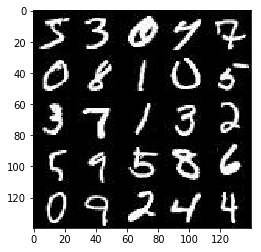

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


# import numpy
import numpy as np

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')


# Had to convert the image to np.array
# This solution was given to me by 'Itai Dror' in the Slack Chat

pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

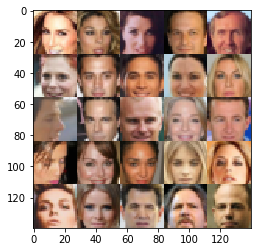

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                 'real_inputs')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')  
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_inputs, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, 'valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
        
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    
    
    
    
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    
    # image was converted to np.array, otherwise don't work for gray scale images
    #pyplot.imshow(images_grid, cmap=cmap)
    
    # This solution was given to me by 'Itai Dror' in the Slack Chat
    
    pyplot.imshow(np.array(helper.images_square_grid(samples, image_mode)), cmap=cmap)
    
    
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
             # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1386... Generator Loss: 10.5091
Epoch 1/2... Discriminator Loss: 0.2862... Generator Loss: 4.1616
Epoch 1/2... Discriminator Loss: 0.0673... Generator Loss: 6.9433
Epoch 1/2... Discriminator Loss: 0.3371... Generator Loss: 2.8247
Epoch 1/2... Discriminator Loss: 3.0418... Generator Loss: 0.0966
Epoch 1/2... Discriminator Loss: 0.0439... Generator Loss: 4.0591
Epoch 1/2... Discriminator Loss: 6.2355... Generator Loss: 0.0174
Epoch 1/2... Discriminator Loss: 0.1792... Generator Loss: 2.4092
Epoch 1/2... Discriminator Loss: 0.1183... Generator Loss: 2.8500
Epoch 1/2... Discriminator Loss: 0.1453... Generator Loss: 2.8835


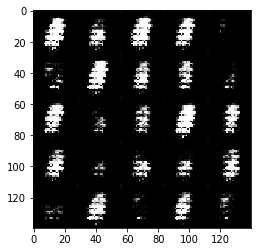

Epoch 1/2... Discriminator Loss: 0.5454... Generator Loss: 2.0635
Epoch 1/2... Discriminator Loss: 0.6723... Generator Loss: 6.5517
Epoch 1/2... Discriminator Loss: 0.1922... Generator Loss: 3.2555
Epoch 1/2... Discriminator Loss: 2.1817... Generator Loss: 0.9163
Epoch 1/2... Discriminator Loss: 0.5565... Generator Loss: 1.8935
Epoch 1/2... Discriminator Loss: 0.2717... Generator Loss: 2.7403
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 1.1430
Epoch 1/2... Discriminator Loss: 0.4484... Generator Loss: 1.6870
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 7.5940
Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 1.3508


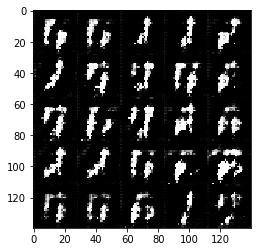

Epoch 1/2... Discriminator Loss: 0.7476... Generator Loss: 1.3664
Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 2.2356
Epoch 1/2... Discriminator Loss: 0.4733... Generator Loss: 1.3971
Epoch 1/2... Discriminator Loss: 1.8102... Generator Loss: 8.5437
Epoch 1/2... Discriminator Loss: 0.4252... Generator Loss: 2.2795
Epoch 1/2... Discriminator Loss: 0.2700... Generator Loss: 2.4453
Epoch 1/2... Discriminator Loss: 0.5658... Generator Loss: 2.1764
Epoch 1/2... Discriminator Loss: 0.8822... Generator Loss: 0.9638
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 1.2899


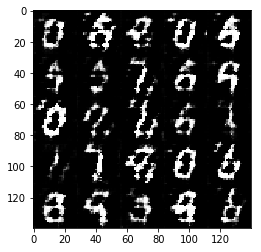

Epoch 1/2... Discriminator Loss: 0.7535... Generator Loss: 2.1771
Epoch 1/2... Discriminator Loss: 1.7251... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 0.5038... Generator Loss: 2.0912
Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 3.6077
Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 4.9906
Epoch 1/2... Discriminator Loss: 0.2544... Generator Loss: 3.7773
Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 0.5101
Epoch 1/2... Discriminator Loss: 0.8896... Generator Loss: 1.9414
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.7982


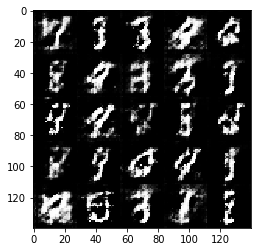

Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 2.5513
Epoch 1/2... Discriminator Loss: 0.5144... Generator Loss: 1.8951
Epoch 1/2... Discriminator Loss: 0.6246... Generator Loss: 1.7986
Epoch 1/2... Discriminator Loss: 0.7247... Generator Loss: 2.0300
Epoch 1/2... Discriminator Loss: 0.7489... Generator Loss: 1.2873
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 3.2121
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.3674
Epoch 1/2... Discriminator Loss: 0.5452... Generator Loss: 1.5820
Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 2.1678
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 2.5041


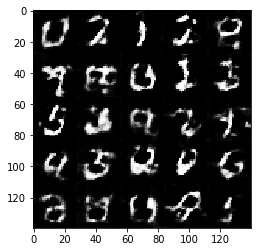

Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 1.6989
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 1.6299
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.8419
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 2.6585
Epoch 1/2... Discriminator Loss: 0.9034... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.5615
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 1.4267
Epoch 1/2... Discriminator Loss: 0.4870... Generator Loss: 2.5844
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 0.7098


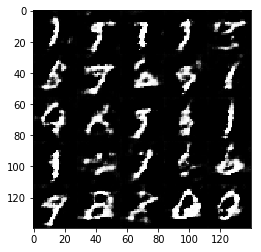

Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 1.7828
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 1.3050
Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 0.8866
Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 1.3812
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 1.4246
Epoch 1/2... Discriminator Loss: 0.6800... Generator Loss: 1.6431
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.7210
Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 0.9828
Epoch 1/2... Discriminator Loss: 0.6531... Generator Loss: 1.6536
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.8081


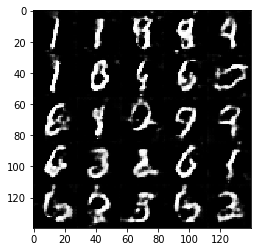

Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.3593
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 1.0518... Generator Loss: 2.6585
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 1.4381
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 0.6650... Generator Loss: 2.0809
Epoch 1/2... Discriminator Loss: 0.7506... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 2.1194... Generator Loss: 0.2365
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 1.7219
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 1.1654


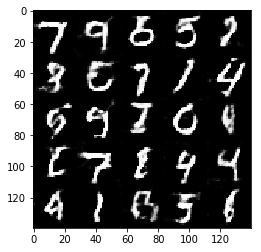

Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 1.4688
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 0.6520... Generator Loss: 1.5656
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.5940
Epoch 1/2... Discriminator Loss: 0.8732... Generator Loss: 1.4850
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 1.4916
Epoch 1/2... Discriminator Loss: 0.7133... Generator Loss: 1.8601
Epoch 1/2... Discriminator Loss: 0.7767... Generator Loss: 2.3185
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.5649


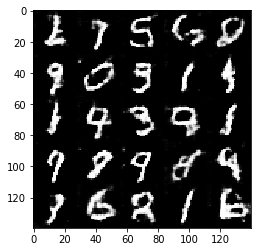

Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 0.9594
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 0.9223... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 0.7929... Generator Loss: 1.0472
Epoch 2/2... Discriminator Loss: 0.7034... Generator Loss: 1.4184
Epoch 2/2... Discriminator Loss: 0.7837... Generator Loss: 1.5912
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.3161
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.4663
Epoch 2/2... Discriminator Loss: 1.7800... Generator Loss: 0.3290
Epoch 2/2... Discriminator Loss: 1.2065... Generator Loss: 0.5286


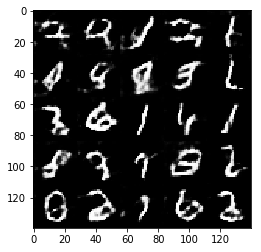

Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 1.2371
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 0.9838
Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.3989
Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 2.3479
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.6545
Epoch 2/2... Discriminator Loss: 0.7293... Generator Loss: 1.4400
Epoch 2/2... Discriminator Loss: 1.0684... Generator Loss: 2.2445
Epoch 2/2... Discriminator Loss: 2.5204... Generator Loss: 2.8347
Epoch 2/2... Discriminator Loss: 1.5621... Generator Loss: 0.3797


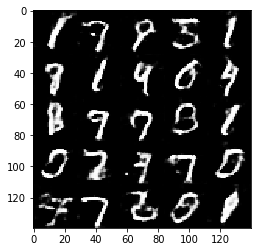

Epoch 2/2... Discriminator Loss: 0.8154... Generator Loss: 1.1947
Epoch 2/2... Discriminator Loss: 1.0920... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 0.9116
Epoch 2/2... Discriminator Loss: 0.7252... Generator Loss: 1.6660
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.5994
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.5948
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 1.1642
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.5739
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 0.7993


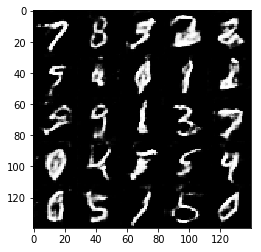

Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.2093
Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 1.2618
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.5032
Epoch 2/2... Discriminator Loss: 0.8680... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 1.7684
Epoch 2/2... Discriminator Loss: 1.0617... Generator Loss: 1.1131
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.6309
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 1.2253... Generator Loss: 2.7232


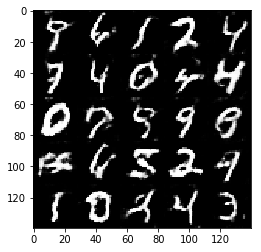

Epoch 2/2... Discriminator Loss: 0.7878... Generator Loss: 1.3529
Epoch 2/2... Discriminator Loss: 2.5851... Generator Loss: 3.3229
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 0.7620
Epoch 2/2... Discriminator Loss: 1.0156... Generator Loss: 1.2673
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.5721
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 0.6586... Generator Loss: 1.4643
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 0.9604


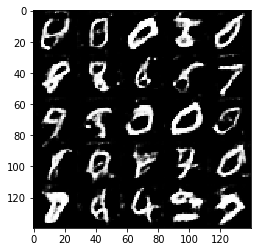

Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.6387
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 2.4044
Epoch 2/2... Discriminator Loss: 1.5992... Generator Loss: 0.3550
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 1.3074
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 0.6526
Epoch 2/2... Discriminator Loss: 0.9729... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 0.8900
Epoch 2/2... Discriminator Loss: 1.7823... Generator Loss: 0.3005
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 0.8596


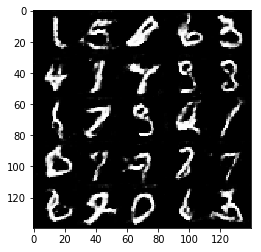

Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.2857
Epoch 2/2... Discriminator Loss: 0.7921... Generator Loss: 1.1848
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.4309
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.3691
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 0.6923
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 2.8567
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 1.4564
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.6865


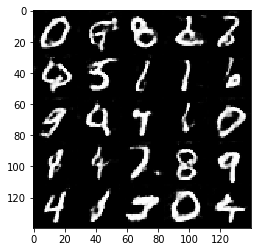

Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 0.7960
Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.3149
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.1759
Epoch 2/2... Discriminator Loss: 0.9281... Generator Loss: 1.8293
Epoch 2/2... Discriminator Loss: 0.8041... Generator Loss: 0.9851
Epoch 2/2... Discriminator Loss: 1.1099... Generator Loss: 0.6113


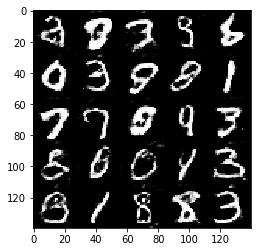

Epoch 2/2... Discriminator Loss: 1.2906... Generator Loss: 0.5527
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 1.2540
Epoch 2/2... Discriminator Loss: 1.5377... Generator Loss: 3.1888
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 1.6695
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.5538
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.0524
Epoch 2/2... Discriminator Loss: 1.4651... Generator Loss: 0.6017


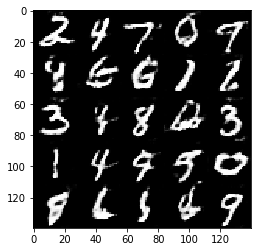

Epoch 2/2... Discriminator Loss: 1.2521... Generator Loss: 0.7169
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 0.5522
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.6314
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 0.5463
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 2.6688
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.6883
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 0.5512


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
rgb = 'RGB'

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 1.8641
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 3.1882
Epoch 1/1... Discriminator Loss: 2.9352... Generator Loss: 7.9303
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 2.2985
Epoch 1/1... Discriminator Loss: 0.0874... Generator Loss: 4.4666
Epoch 1/1... Discriminator Loss: 0.1578... Generator Loss: 3.3855
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 8.5985
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 4.4849
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 4.4192
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 4.1342


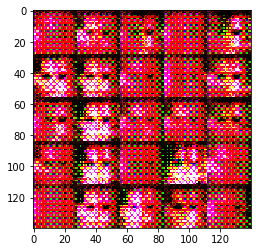

Epoch 1/1... Discriminator Loss: 1.7880... Generator Loss: 4.6309
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 4.5056
Epoch 1/1... Discriminator Loss: 5.7953... Generator Loss: 0.0139
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 2.3461
Epoch 1/1... Discriminator Loss: 0.1184... Generator Loss: 2.5876
Epoch 1/1... Discriminator Loss: 0.0377... Generator Loss: 4.6105
Epoch 1/1... Discriminator Loss: 0.0399... Generator Loss: 5.3342
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.8308
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 3.5350
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 1.9056


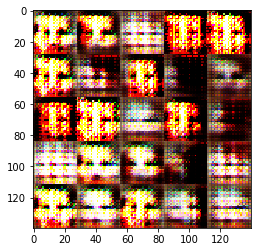

Epoch 1/1... Discriminator Loss: 0.1758... Generator Loss: 2.3378
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 0.1535... Generator Loss: 2.1841
Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 2.7781
Epoch 1/1... Discriminator Loss: 0.1704... Generator Loss: 2.4758
Epoch 1/1... Discriminator Loss: 0.3141... Generator Loss: 1.7828
Epoch 1/1... Discriminator Loss: 0.1778... Generator Loss: 2.6702
Epoch 1/1... Discriminator Loss: 2.2038... Generator Loss: 1.3792
Epoch 1/1... Discriminator Loss: 0.2247... Generator Loss: 2.2969
Epoch 1/1... Discriminator Loss: 0.2879... Generator Loss: 2.8654


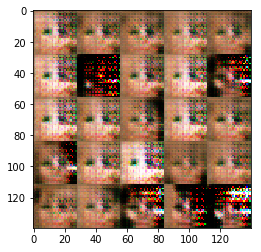

Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 2.4078
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 1.9812
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 2.0049
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 1.6668
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 2.9231
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 1.1837


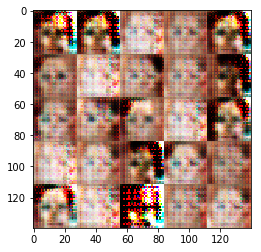

Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.6972... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.5383
Epoch 1/1... Discriminator Loss: 0.6783... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 2.5899
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.7671


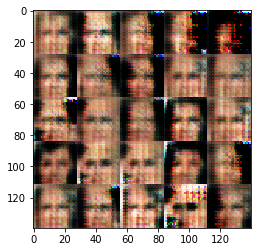

Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.9225... Generator Loss: 2.5317
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 1.2532
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.6395


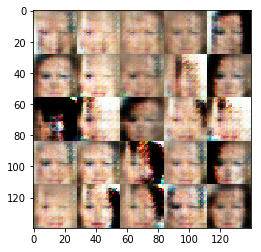

Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.8271
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 2.2193
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.4675
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 3.0715
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 2.5602
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.6165


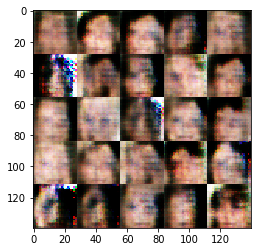

Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 1.2686


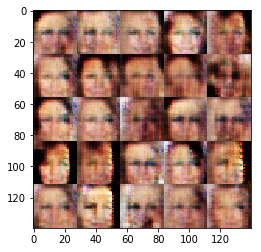

Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 3.0324
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.8811


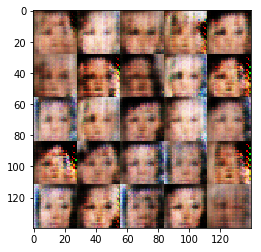

Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 2.0929
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.9330
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.7888... Generator Loss: 3.2390
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.3995


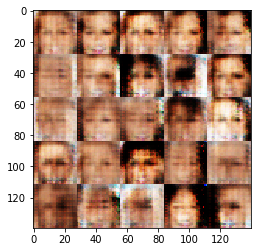

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 3.0766
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 3.3617
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 3.2507
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.3880


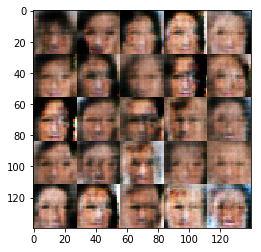

Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.7925
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 2.8063
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 0.8025


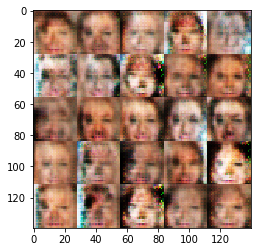

Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.8673
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.4509
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.8416
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.1998
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.7535


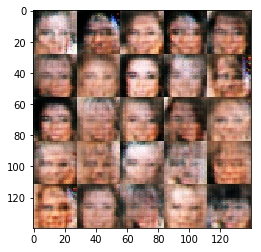

Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.6321
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 1.9058
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 1.5212
Epoch 1/1... Discriminator Loss: 3.0111... Generator Loss: 0.0975
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.0362


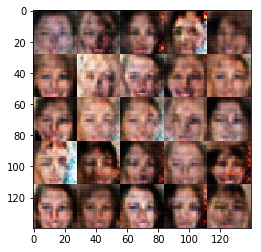

Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 2.4153
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.9623
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.2887


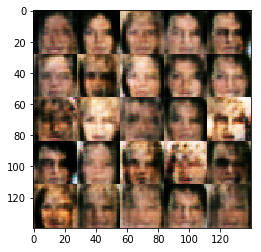

Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.7805... Generator Loss: 2.7543
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.6220


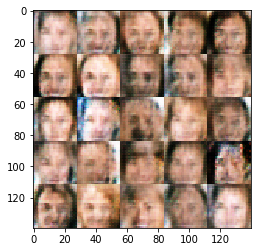

Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 2.3300
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.3349
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.0857
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 1.4585
Epoch 1/1... Discriminator Loss: 2.8769... Generator Loss: 3.4755
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.0167
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 1.9261
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.5452


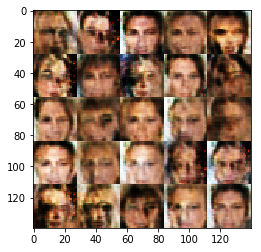

Epoch 1/1... Discriminator Loss: 1.9538... Generator Loss: 1.4866
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.2905
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.4378
Epoch 1/1... Discriminator Loss: 1.9132... Generator Loss: 0.2627
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 2.0835... Generator Loss: 3.1963
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6333


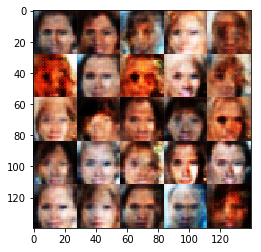

Epoch 1/1... Discriminator Loss: 0.2075... Generator Loss: 2.6240
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.6103


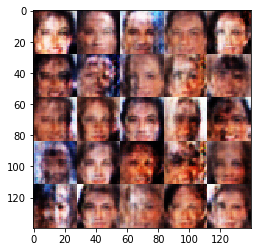

Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 2.1886
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.6312
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.8077
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.6966


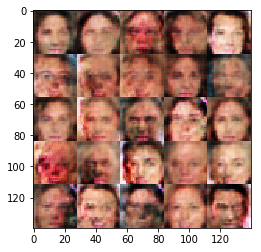

Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 2.0174
Epoch 1/1... Discriminator Loss: 2.4666... Generator Loss: 3.7159
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 1.5461
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 0.1713... Generator Loss: 2.6684
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.9131


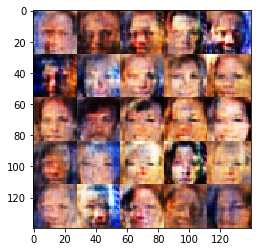

Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 1.0094


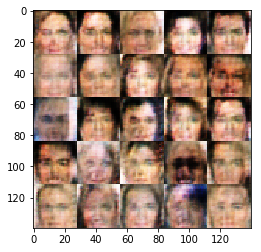

Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.4186
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.5965


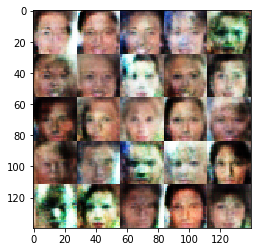

Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.3859
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 0.7845


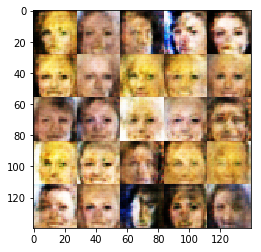

Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 2.4377... Generator Loss: 4.9547
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 0.9778


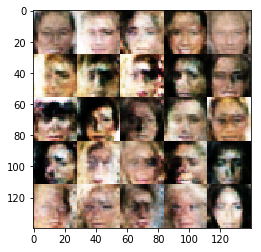

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 2.3625
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.4136
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.8600


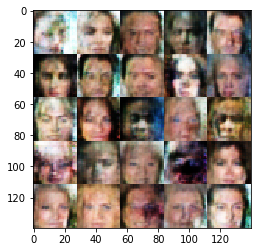

Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 1.8690
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.2920
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 2.2485
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 4.3673
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.2034


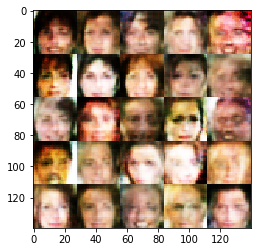

Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 1.3916
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7307


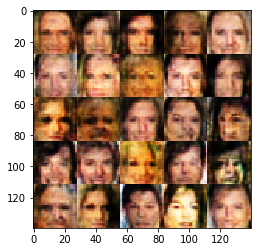

Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.3854
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.4463
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.6106


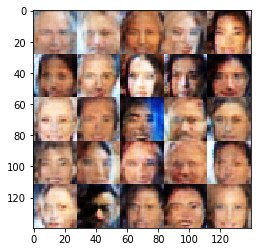

Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 2.1272... Generator Loss: 2.4708
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.3316
Epoch 1/1... Discriminator Loss: 0.2956... Generator Loss: 2.1678
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.9249


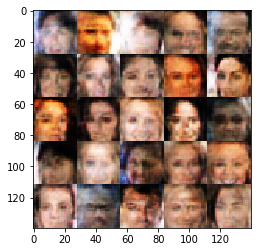

Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7244


In [ ]:
%%time
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.